In [1]:
import numpy as np
import os, sys
from skimage import io
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import neuroglancer
from PIL import Image
from scipy.ndimage import zoom

In [1]:
from os.path import join as pjoin
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi
from dipy.data.fetcher import fetch_syn_data
from dipy.io.image import load_nifti
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

/usr/local/share/pipeline/lib/python3.10/site-packages/dipy/viz/__init__.py:20: UserWarning: You do not have FURY installed. Therefore, 3D visualization functions will not work for you. Please install or upgrade FURY using pip install -U furyFor detailed installation instructions visit: https://fury.gl/
  warnings.warn(


In [2]:
files, folder = fetch_stanford_hardi()
static_data, static_affine, static_img = load_nifti(
                                            pjoin(folder, 'HARDI150.nii.gz'),
                                            return_img=True)
static = np.squeeze(static_data)[..., 0]
static_grid2world = static_affine

  0%|          | 0/5578 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

In [20]:
static_affine

array([[   2.,    0.,    0.,  -80.],
       [   0.,    2.,    0., -120.],
       [   0.,    0.,    2.,  -60.],
       [   0.,    0.,    0.,    1.]])

In [3]:
animal = 'DK55'
ROOT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data'

boundary_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'boundaries.tiff')
boundary_stack = io.imread(boundary_path)

downsampled_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'downsampled.tiff')
downsampled_stack = io.imread(downsampled_path)

atlas_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'registered_atlas_original_orientation.tiff')
atlas_stack = io.imread(atlas_path)

In [18]:
volume = np.swapaxes(atlas_stack, 0,2)

In [14]:
fpath = os.path.join(ROOT, animal,  'preps/CH1/thumbnail_aligned')
files = os.listdir(fpath)
z = len(files)
midfile = str(z // 2).zfill(3) + ".tif"
midfilepath = os.path.join(ROOT, animal,  f'preps/CH1/thumbnail_aligned/{midfile}')
mid_arr = io.imread(midfilepath)
print(midfile,z, mid_arr.shape) 

242.tif 485 (1546, 2359)


In [17]:
change_y = mid_arr.shape[0] / volume.shape[0]
change_x = mid_arr.shape[1] / volume.shape[1]
change_z = z / volume.shape[2]
print(change_y, change_x, change_z)

1.5759429153924567 3.6687402799377917 1.25


In [19]:
zatlas = zoom(volume, (change_y, change_x, change_z))
print('zatlas',zatlas.shape, zatlas.dtype, np.amin(zatlas), np.amax(zatlas), np.mean(zatlas))
print('volume', mid_arr.shape, z)

In [5]:

#volume = atlas_stack.copy()
#volume = volume.astype(np.uint8) * 255
print(volume.shape, volume.dtype, np.amin(volume), np.amax(volume), np.mean(volume))

(981, 643, 388) uint32 0 614454277 1640321.4506582196


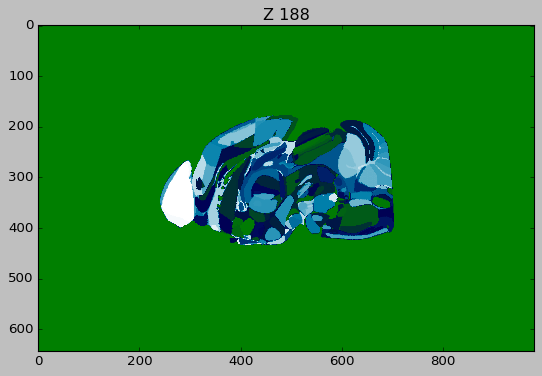

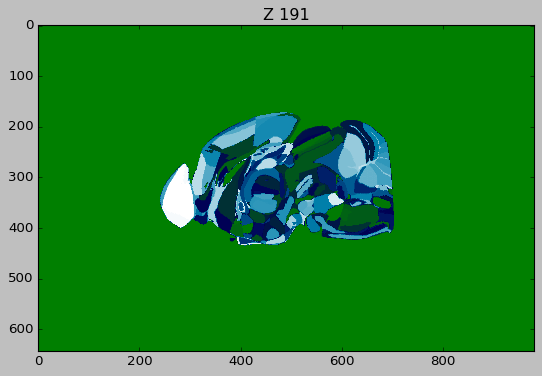

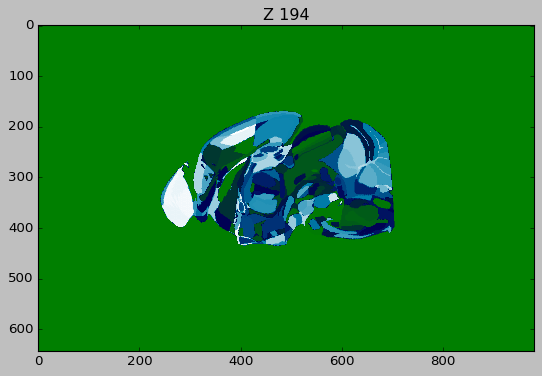

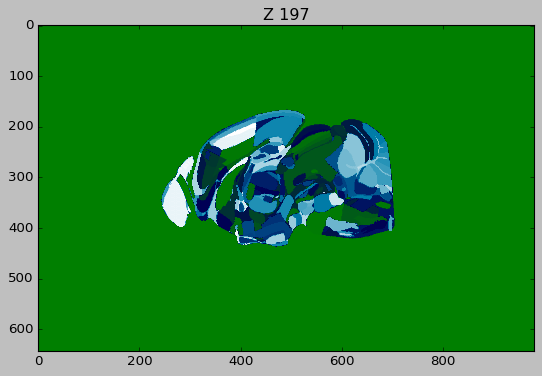

In [8]:
arr = volume.astype(np.uint8).copy()
#arr = np.rot90(arr, 3)
midsection = arr.shape[2] // 2 
n = 6  
start = midsection - n
end = midsection + n
plt.style.use('classic')
for i in range(start, end,3):
    img = arr[:,:,i]
    img = np.rot90(img, 3)
    img = np.flip(img, axis=1)
    plt.title('Z {}'.format(i))
    plt.imshow(img, cmap="ocean")
    plt.show()

In [17]:
ROOT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data'
boundary_outpath = os.path.join(ROOT, animal, 'preps/CH1/boundary')
os.makedirs(boundary_outpath, exist_ok=True)
testfile_path = os.path.join(ROOT, animal, 'preps/CH1/thumbnail_aligned/000.tif')
testfile = Image.open(testfile_path)
size = testfile.size
arr = volume.copy()
#arr = np.rot90(arr, 3)
endsection = arr.shape[2]   
for i in tqdm(range(0, endsection, 1)):
    img = arr[:,:,i]
    img = np.rot90(img, 3)
    img = np.flip(img, axis=1)    
    pimg = Image.fromarray(img.astype(np.uint8))
    img = pimg.resize(size, Image.Resampling.LANCZOS)
    f = str(i).zfill(3) + '.tif'
    outpath = os.path.join(boundary_outpath, f)
    #print(i,outpath, img.shape, img.dtype)
    img.save(outpath)
    


100%|██████████| 388/388 [00:17<00:00, 22.68it/s]


In [19]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='um',
    scales=[10.4, 10.4, 20])

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=volume,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol invlerp normalized

void main() {
    float pix =  normalized();
  	  emitGrayscale(pix) ;
}
""")
print(viewer)

http://127.0.0.1:43601/v/878a282262c3cfcfbf0bc353b8f02e3b92f5c0c8/


In [17]:
OUTPATH = os.path.join(HOME, 'work','tifs')
arr = volume.copy()
arr = np.rot90(arr, 3)
start = 0
end = arr.shape[2]
for i in range(start, end,1):
    outfile = str(i).zfill(3) + '.tif'
    outpath = os.path.join(OUTPATH, outfile)
    cv2.imwrite(outpath, arr[:,:,i])